# Universidad de Buenos Aires
# Deep Learning - Examen



In [1]:
import pandas as pd
import numpy as np
from scipy import stats


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams["axes.grid"] =True

from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Ejercicio 1



Se quiere encontrar el máximo de la siguiente función:

$z = -(x - 2)^2 - (y - 3)^2 + 4$

(a) Aplicar gradiente e igualar a zero para encontrar los valores de x e y donde z tiene un máximo. Cuál es el valor del máximo?

(b) Aplicar SGD para encontrar la ubicación del máximo de manera numérica.

El gradiente de z tiene dos componentes, dz/dx y dz/dy, debemos igualar ambos a cero para poder encontrar un máximo.
$
dz/dx = -2 * (x - 2) = 0 => x = 2
$
<br>
$
dz/dy = -2 * ( y - 3) = 0 => y = 3
$
<br>
$
Zmax = - ( 2 - 2)^2 - (y - 3) ^ 2 + 4 = 4
$

In [2]:
def loss_function(x, y):
    z = - np.power(x-2,2) - np.power(y-3,2) + 4
    return z


def gradient(x, y):
    grad_x = -2*(x-2)
    grad_y = -2*(y-3)
    return grad_x, grad_y

def StochasticGradientDescent(x, y, lr, epochs, tolerance):
    losses=[]
    x_values=[]
    y_values=[]
    for i in range(epochs):
        x_values.append(x)
        y_values.append(y)
        loss=loss_function(x,y)
        losses.append(loss)
        grad_x, grad_y = gradient(x,y)
        x2=x+lr*grad_x
        y2=y+lr*grad_y
        if (np.abs(x2-x)<tolerance) & (np.abs(y2-y)<tolerance):
            break
        x=x2
        y=y2
    
    fig, ax = plt.subplots(3,figsize=(10,10))
    ax[0].plot(losses,c='blue')
    ax[0].set_title("Loss")
    ax[1].plot(x_values,c='red')
    ax[1].set_title("x values")
    ax[2].plot(y_values,c='red')
    ax[2].set_title("y values")
    ax[2].set_xlabel("Epochs")
    
    
    return x,y,loss

X max: 1.955727814223097
Y_max: 3.0295147905179354
Z_max: 3.997168850707218


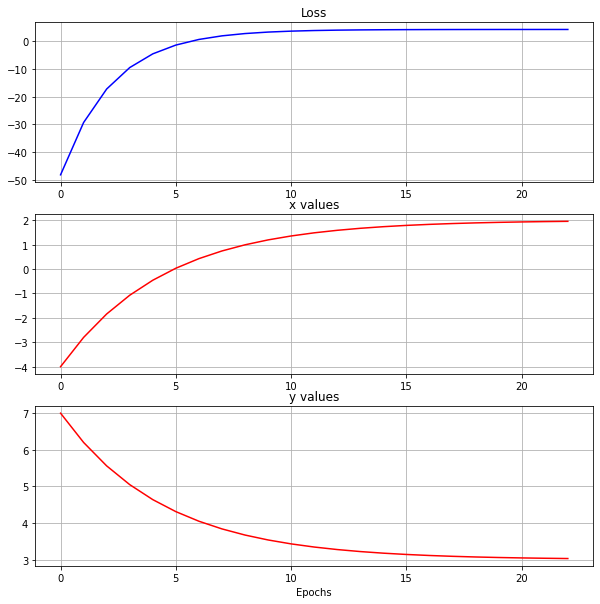

In [3]:
x_max,y_max,z_max=StochasticGradientDescent(-4,7,0.1,30,tolerance=0.01)
print("X max: {}".format(x_max))
print("Y_max: {}".format(y_max))
print("Z_max: {}".format(z_max))

**Se verifica la correspondencia entre los valores calculados numéricamente y los valores calculados analíticamente**

## Ejercicio 2 

Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing

El dataset son compras de productos que diferentes clientes realizaron durante el black sales.

El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuanto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gatar mucha plata (más de 9000) o poca plata (menos de 9000).

Vamos a construir 5 modelos:

* Un modeo que siempre predice que los clientes gastan mucha plata en todos los productos.
* Un modelo del tipo de Regresión Logīstica Lineal. 
* Un modelo del tipo Random Forest.
* Un modelo del tipo Deep Learning sin embeddings.
* Un modelo del tipo Deep Learning con embeddings.

A continuación está el código para conectar Google Drive, algunos imports que vas a necesitar (podes agregar más) y el comando para levantar el dataset.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path_to_ds = "/content/drive/MyDrive/black_sales.csv"
df_train = pd.read_csv(path_to_ds)

### (a) Análisis de datos

1. Imprimir las 5 primeros filas del dataset. 
2. Imprimir los tipos de cada columna del dataset.
3. Imprimir las estadísticas básicas de cada columnas. 
4. Hacer un histograma de la variable Purchase.
5. Que columnas son categóricas y cuales son numéricas?
6. Para las columnas categóricas, cuántas clases únicas tienen cada una?

In [6]:
# Punto 1
df_train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
# Punto 2
df_train.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [8]:
# Punto 3
df_train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [9]:
len(df_train)

550068

(array([ 36844.,  57919., 132275., 104918.,  76784.,  30178.,  64558.,
         12695.,  31539.,   2358.]),
 array([1.20000e+01, 2.40690e+03, 4.80180e+03, 7.19670e+03, 9.59160e+03,
        1.19865e+04, 1.43814e+04, 1.67763e+04, 1.91712e+04, 2.15661e+04,
        2.39610e+04]),
 <a list of 10 Patch objects>)

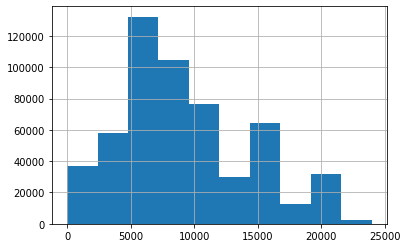

In [10]:
# Punto 4
purchase = df_train.Purchase.to_numpy()
fig, ax1 = plt.subplots(1,1)
ax1.hist(purchase)

Punto 5

Observando los tipos de datos y la cantidad de elementos únicos de las columnas podemos decir que la únicas variable numérica es "Purchase". 

Nota: Ocuppation debería analizarse un poco en mayor profundidad si es  numérica o corresponde a categorías. En principo la consideramos categórica.

La edad también podría haber sido numérica pero en el dataset esta planteado como rango etario, es decir, lo utiliza como una categoría. Lo mismo sucede con Stay_In_Current_City_years que posee una categoría para 4 o mas años.

Dicho lo anterior, las variables categóricas serían: 

User_ID, Product_ID, Gender, Age, City_Category, Stay_In_Current_City_Years, Marital_Status, Product_Catgory_1, Product_Catgory_2, Product_Catgory_3 

In [11]:
# Punto 6
print(df_train.apply(lambda col: len(col.unique())))

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               18
Product_Category_3               16
Purchase                      18105
dtype: int64


Observamos que User_Id y Product_Id poseen alta cardinalidad

### (b) Limpieza de datos

1. Que columnas tienen NaNs?
2. Si la cantidad de filas afectas por NaNs es grande, se propone reemplazar los NaNs por una nueva clase, por ejemplo el valor 999. 


In [12]:
print(df_train.apply(lambda col: col.isnull().sum()))

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


Observamos que solo Product_Category_2 y Product_Category_3 posee NaN, reemplazamos estos por el valor 999

In [13]:
df_train.loc[df_train.Product_Category_2.isna(),'Product_Category_2']=999
df_train.loc[df_train.Product_Category_3.isna(),'Product_Category_3']=999

In [14]:
print(df_train.apply(lambda col: col.isnull().sum()))

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


### (c) Ingeniería de features

1. Transformar todas las variables categoricas (expecto User_Id y Prdoct_Id) en one-hot-encoding. 
2. Crear un index para User_Id y Product_id, para poder entrenar un modelo de Deep Learning con embeddings.
3. Porque es importante crear un index para entrenar el modelo de Deep Learning con embeddings?
4. Porque es importante guardar el mapping de id a index?
5. Transformar la variable Purchase en una variable purchase_binary, tal que todos los valores mayores a 9000 hagan un mapping a 1 y todos los valores menores o iguales a 9000 hagan un mapping a 0.
6. Normalizar todos los valores entre 0 y 1.
7. Hacer un split del dataset en training (70%), validation (20%) y testing (10%). Para crear el dataset de training se recomienda separar User_id y Product_id de la matriz x_train, x_valid y x_test. Pero también obtener user_idx_train, user_idx_valid y user_idex_test de tal manera que sea correspondientes con las matrices x. Lo mismo para el Product_Id. 

In [15]:
# Punto 1
y = pd.get_dummies(df_train.Gender, prefix="Gender")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Age, prefix="Age")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Occupation, prefix="Occupation")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.City_Category, prefix="City")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Stay_In_Current_City_Years, prefix="Stay")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Marital_Status, prefix="Marital")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Product_Category_1, prefix="ProdCat1")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Product_Category_2, prefix="ProdCat2")
df_train = pd.concat([df_train,y], axis=1)

y = pd.get_dummies(df_train.Product_Category_3, prefix="ProdCat3")
df_train = pd.concat([df_train,y], axis=1)

In [16]:
# Punto 2
user_u, user_indices, user_inverse = np.unique(df_train.User_ID, return_index=True, return_inverse=True)
# Mapeo el vendor id a un número de indice
user_id_to_index = {key:value for key,value in zip(user_u,user_inverse)}
user_index = np.array([user_id_to_index[id] for id in df_train.User_ID])

In [17]:
product_u, product_indices, product_inverse = np.unique(df_train.Product_ID, return_index=True, return_inverse=True)
# Mapeo el vendor id a un número de indice
product_id_to_index = {key:value for key,value in zip(product_u,product_inverse)}
product_index = np.array([product_id_to_index[id] for id in df_train.Product_ID])

**Punto 3**

El layer embedding usa índices enteros de una tabla para hacer la correspondencia feature de entrada con el vector de números reales de salida(embeddings). Por lo tanto, dado que User_Id y Product_Id no tienen la codificación necesaria, creamos un indíce donde mapeamos previamente los valores únicos de User_id y Product_Id a enteros consecutivos. 

**Punto 4**

El mapping de id a index lo necesitamos para hacer la transformación a enteros consecutivos, no solo en la etapa de entrenamiento sino también cuando corramos el modelo sobre nuevos datos. Antes de ejecutar el modelo sobre nuevos datos, los id deben ser adecuadamente transformados a index

In [18]:
# Punto 5
df_train['purchase_binary'] = df_train.Purchase.apply(lambda label:0 if label<=9000 else 1)

In [19]:
# Punto 6
df_final = df_train.drop(['User_ID', 'Product_ID','Gender','Age','City_Category', 'Occupation','Stay_In_Current_City_Years','Marital_Status','Product_Category_1',\
               'Product_Category_2','Product_Category_3', 'Purchase', 'purchase_binary'],axis=1, inplace=False)

y_final = df_train['purchase_binary']

In [20]:
scaler = MinMaxScaler()
df_final=scaler.fit_transform(df_final)

In [21]:
# Punto 7
x_train, x_test, Y_train, Y_test, user_train, user_test, product_train, product_test = \
    model_selection.train_test_split( df_final, y_final, user_index, product_index, test_size=0.1, random_state=5)

x_train, x_valid, Y_train, Y_valid, user_train, user_valid, product_train, product_valid= \
    model_selection.train_test_split( x_train, Y_train, user_train, product_train, test_size=0.22222222, random_state=5)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(385047, 94)
(110014, 94)
(55007, 94)


### (d) Modelo base

1. Entrenar un modelo base que siempre de como predicción que el purchase del cliente es de valor elevado.
2. Calcular el AUC de este modelo.
3. Porque es importante siempre definir un modelo base?

In [22]:
class ConstantModel(object):
    def fit(self, X, y):
        return None

    def predict(self,X):
        return np.ones(shape=(X.shape[0]))

    def predict_proba(self, X):
        return np.ones(shape=(X.shape[0]))

In [23]:
base_model = ConstantModel()
base_model.fit(x_train,Y_train)

predictions = base_model.predict_proba(x_train)
train_auc = roc_auc_score(Y_train, predictions)
print(f"Train AUC for constant model: {train_auc}")

predictions = base_model.predict_proba(x_valid)
valid_auc = roc_auc_score(Y_valid, predictions)
print(f"Valid AUC for constant model: {valid_auc}")

Train AUC for constant model: 0.5
Valid AUC for constant model: 0.5


Es importante definir un modelo base para tener una idea del valor mínimo de las métricas del problema que cualquier modelo que realmente funcione debe superar.

### (e) Regresión logísica

1. Entrenar un modelo de regresión logística que sea mejor que el modelo base (no usar User_Id y Product_Id). 
2. Porque es importante normalizar los datos antes de entrenar el modelo de regresión logística?
3. Porque es importante utilizar una metrica como AUC en un problema de clasificación binaria?

In [24]:
# Punto 1
lr_model = LogisticRegression(C=1, solver='sag', max_iter=1000)
lr_model.fit(x_train,Y_train)

predictions = lr_model.predict_proba(x_train)
train_auc = roc_auc_score(Y_train, predictions[:,1])
print(f"Train AUC for Logistic Regresion: {train_auc}")

predictions = lr_model.predict_proba(x_valid)
valid_auc = roc_auc_score(Y_valid, predictions[:,1])
print(f"Valid AUC for Logistic Regresion: {valid_auc}")

Train AUC for Logistic Regresion: 0.9279971232654155
Valid AUC for Logistic Regresion: 0.9276061531235704


**Punto 2**

Si no normalizamos los datos antes de entrenar el modelo, tenemos a la entrada features con diferentes escalas. Los features con escalas mayores, me van a demandar que el learning rate sea pequeño, lo cual me vuelve muy lento el entrenamiento de las features de menor escala. Si por el contrario elijo un learning rate acorde a las features de menor escala, me generan gradientes muy grandes para los features de mayor escala (con el riesgo que esto supone).

También, en el caso de regresión logística, tenemos en el camino de cómputo una sigmoid antes de la loss function.
La sigmoid tiene como característica que su derivada (utilizada al calcular el backpropagation) posee valores muy pequeños para altos valores la entrada; es decir, cuando la entrada es grande, entrena en forma muy lenta ("Vanishing Gradient"). Esta situación se puede dar en caso de no normalizar el dataset.


**Punto 3**

El AUC resume que tan bien detecta el modelo las clases 0 y 1 para diferentes valores de umbral de probabilidad. Es decir, me dice que tan bien separa o distingue el modelo la clase 0 de la clase 1. Resulta entonces muy útil para comparar los diferentes modelos.

### (f) Random forest

1. Entrenar un modelo de Random Forest que sea mejor que el modelo base (no usar User_Id y Product_Id).

In [25]:
# Punto 1
rf_model = RandomForestClassifier(n_estimators=10, max_depth=None, random_state=0)
rf_model.fit(x_train, Y_train)

predictions = rf_model.predict_proba(x_train)
train_auc = roc_auc_score(Y_train, predictions[:,1])
print(f"Train AUC for Random Fores: {train_auc}")

predictions = rf_model.predict_proba(x_valid)
valid_auc = roc_auc_score(Y_valid, predictions[:,1])
print(f"Valid AUC for Random Forest: {valid_auc}")

Train AUC for Random Fores: 0.97202135796404
Valid AUC for Random Forest: 0.9193410586157573


### (g) Deep learning sin embeddings

1. Entrenar un modelo de Deep Learning que no utilice embeddings (no usar User_Id y Product_Id).

In [26]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
      self.X=X
      self.Y=Y
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:], self.Y[idx]
  

class TestCustomDataset(Dataset):
    def __init__(self, X):
      self.X=X
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:]


class NNetLayers(torch.nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=n_inputs, out_features=10, bias = True)
        self.activation_1 = torch.nn.ReLU()
        self.dropout_1= torch.nn.Dropout(p=0.05)
        self.linear_2 = torch.nn.Linear(in_features=10, out_features=20, bias = True)
        self.activation_2 = torch.nn.ReLU()
        self.dropout_2= torch.nn.Dropout(p=0.05)
        self.linear_3 = torch.nn.Linear(in_features=20, out_features=1, bias = True)
        self.activation_3 = torch.nn.Sigmoid()

    def forward(self, x):
        # X es el batch que va a entrar
        z1 = self.linear_1(x)
        a1 = self.activation_1(z1)
        d1 = self.dropout_1(a1)
        z2 = self.linear_2(d1)
        a2 = self.activation_2(z2)
        d2 = self.dropout_2(a2)
        z3 = self.linear_3(d2)
        y = self.activation_3(z3)
        return y
  
    
class NnetBinaryClass():
    
    def __init__(self, n_inputs):
        self.nnet = NNetLayers(n_inputs)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pass
    
        
    def fit(self,x_train, y_train, x_valid=None, y_valid=None, \
            batch_size = 32, lr=0.001, epochs=10, verbose=True):
        
        training_set = CustomDataset(x_train, y_train)
        training_dataloader = DataLoader(training_set,batch_size=batch_size, \
                                         shuffle=True)
        
        if (x_valid is not None) & (y_valid is not None):
            valid_set = CustomDataset(x_valid, y_valid)     
            valid_dataloader = DataLoader(valid_set,batch_size=len(valid_set), \
                                          shuffle= True)
        
        # Optimizer
        criterion = torch.nn.BCELoss(reduction='sum')
        optimizer = torch.optim.Adam(self.nnet.parameters(),\
                                    lr=0.001)
    
        # Training
        self.nnet.to(self.device)
        
        history_loss=[]
        history_train_auc=[]
        history_valid_auc=[]
        for epoch in range(epochs):
            running_loss = 0
            nnet_train_scores = []
            train_truth = []
            self.nnet.train()
            for i, data in enumerate(training_dataloader):
                # data es una tupla batch (data, label)
                x, y = data #todavia esta en numpy
                
                x = x.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                y = y.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
    
                # set gradient to zero
                optimizer.zero_grad()
    
                # forward
                y_hat = self.nnet(x)
    
                # loss
                loss = criterion(y_hat[:,0], y)
    
                # backward
                loss.backward()

                
    
                # update of parameters
                optimizer.step()
    
                # compute loss and statistics
                running_loss += loss.item()
                
                train_truth += list(y.detach().numpy()) 
                nnet_train_scores += list(y_hat[:,0].detach().numpy())
                
            history_loss.append(running_loss/x_train.shape[0])
            
            train_auc = roc_auc_score(train_truth, nnet_train_scores)
            history_train_auc.append(train_auc)
    
            
            if (verbose) & ((epoch) % (epochs/10)==0):
                self.nnet.eval()
                with torch.no_grad():
                        
                    if (x_valid is not None) & (y_valid is not None):
                        
                        nnet_valid_scores = []
                        valid_truth = []
                    
                        for i, data in enumerate(valid_dataloader):
                            # batch
                            x, y = data
                            x = x.to(self.device).float()
                            y = y.to(self.device).float()
                
                            # forward 
                            y_hat = self.nnet(x)
                
                            # accumulate data
                            valid_truth += list(y.detach().numpy()) 
                            nnet_valid_scores += list(y_hat[:,0].detach().numpy())
                               
                        valid_auc = roc_auc_score(valid_truth, nnet_valid_scores)
                        history_valid_auc.append(valid_auc)
            
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " + \
                                  f"train auc: {train_auc} | " + \
                                  f"valid auc: {valid_auc}")
                    else:
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " +\
                                   f"train auc: {train_auc}")
                            
        return history_loss,history_train_auc, history_valid_auc
        
    def predict(self,x):
        self.nnet.eval()
        with torch.no_grad():
            test_set = TestCustomDataset(x)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x = data 
                x = x.to(self.device).float() 
                y_hat = self.nnet(x)
                y_hat = y_hat[:,0].detach().numpy()
                y_hat = y_hat >= 0.5

        return y_hat
    
    def predict_proba(self,x):
        self.nnet.eval()
        with torch.no_grad():
            test_set = TestCustomDataset(x)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x = data 
                x = x.to(self.device).float() 
                y_hat = self.nnet(x)
                y_hat = y_hat[:,0].detach().numpy()

        return y_hat

In [27]:
deep_model = NnetBinaryClass(x_train.shape[1])
loss, train_auc, valid_auc = deep_model.fit(x_train, np.array(Y_train),x_valid,np.array(Y_valid), epochs=1)

print(f"Train AUC for Deep NNet: {train_auc[-1]}")
print(f"Valid AUC for Deep NNet: {valid_auc[-1]}")

Epoch = 0 | loss = 0.3215360442941305 | train auc: 0.9240177538370907 | valid auc: 0.9291772305776226
Train AUC for Deep NNet: 0.9240177538370907
Valid AUC for Deep NNet: 0.9291772305776226


### (h) Deep learning con embeddings

1. Entrenar un model de Deep Learning que utilice embeddings de los usuarios y los productos.

In [28]:
class CustomEmbDataset(Dataset):
    def __init__(self, X, user_index, product_index, Y):
      self.X=X
      self.user_index=user_index
      self.product_index=product_index
      self.Y=Y
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:],self.user_index[idx], self.product_index[idx], self.Y[idx]
  

class TestCustomEmbDataset(Dataset):
    def __init__(self, X, user_index, product_index):
      self.X=X
      self.user_index=user_index
      self.product_index=product_index
    
    def __len__(self):
      return self.X.shape[0]
    
    def __getitem__(self, idx):
      return self.X[idx,:],self.user_index[idx], self.product_index[idx]


class NNetLayersEmb(torch.nn.Module):
    def __init__(self, n_inputs, n_user, user_enc_dim, n_product, product_enc_dim):
        super().__init__()
        self.embedding1 = torch.nn.Embedding(num_embeddings=n_user, embedding_dim=user_enc_dim)
        self.embedding2 = torch.nn.Embedding(num_embeddings=n_product, embedding_dim=product_enc_dim)
        self.linear_1 = torch.nn.Linear(in_features=(n_inputs+user_enc_dim+product_enc_dim), out_features=10, bias = True)
        self.activation_1 = torch.nn.ReLU()
        self.dropout_1= torch.nn.Dropout(p=0.05)
        self.linear_2 = torch.nn.Linear(in_features=10, out_features=20, bias = True)
        self.activation_2 = torch.nn.ReLU()
        self.dropout_2= torch.nn.Dropout(p=0.05)
        self.linear_3 = torch.nn.Linear(in_features=20, out_features=1, bias = True)
        self.activation_3 = torch.nn.Sigmoid()

    def forward(self, x, user_index, product_index):
        user_emb = self.embedding1(user_index)
        product_emb = self.embedding2(product_index)
        final_input = torch.cat([x, user_emb, product_emb], dim=1)
        # X es el batch que va a entrar
        z1 = self.linear_1(final_input)
        a1 = self.activation_1(z1)
        d1 = self.dropout_1(a1)
        z2 = self.linear_2(d1)
        a2 = self.activation_2(z2)
        d2 = self.dropout_2(a2)
        z3 = self.linear_3(d2)
        y = self.activation_3(z3)
        return y
  
    
class NnetEmbBinaryClass():
    
    def __init__(self, n_inputs, n_user, user_enc_dim, n_product, product_enc_dim):
        self.nnet = NNetLayersEmb(n_inputs, n_user, user_enc_dim, n_product, product_enc_dim)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pass
    
        
    def fit(self,x_train, user_train, product_train, y_train, \
            x_valid=None, user_valid=None, product_valid=None, y_valid=None,\
            batch_size = 32, lr=0.001, epochs=10, verbose=True):
        
        training_set = CustomEmbDataset(x_train, user_train, product_train, y_train)
        training_dataloader = DataLoader(training_set,batch_size=batch_size, \
                                         shuffle=True)
        
        if (x_valid is not None) & (y_valid is not None):
            valid_set = CustomEmbDataset(x_valid, user_valid, product_valid, y_valid)     
            valid_dataloader = DataLoader(valid_set,batch_size=len(valid_set), \
                                          shuffle= True)
        
        # Optimizer
        criterion = torch.nn.BCELoss(reduction='sum')
        optimizer = torch.optim.Adam(self.nnet.parameters(),\
                                    lr=0.001)
    
        # Training
        self.nnet.to(self.device)
        
        history_loss=[]
        history_train_auc=[]
        history_valid_auc=[]
        for epoch in range(epochs):
            running_loss = 0
            nnet_train_scores = []
            train_truth = []
            self.nnet.train()
            for i, data in enumerate(training_dataloader):
                # data es una tupla batch (data, label)
                x, user, product, y = data #todavia esta en numpy
                
                x = x.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                user = user.to(self.device).long()
                product = product.to(self.device).long()
                y = y.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
    
                # set gradient to zero
                optimizer.zero_grad()
    
                # forward
                y_hat = self.nnet(x, user, product)
    
                # loss
                loss = criterion(y_hat[:,0], y)
    
                # backward
                loss.backward()

                
    
                # update of parameters
                optimizer.step()
    
                # compute loss and statistics
                running_loss += loss.item()
                
                train_truth += list(y.detach().numpy()) 
                nnet_train_scores += list(y_hat[:,0].detach().numpy())
                
            history_loss.append(running_loss/x_train.shape[0])
            
            train_auc = roc_auc_score(train_truth, nnet_train_scores)
            history_train_auc.append(train_auc)
    
            
            if (verbose) & ((epoch) % (epochs/10)==0):
                self.nnet.eval()
                with torch.no_grad():
                        
                    if (x_valid is not None) & (y_valid is not None):
                        
                        nnet_valid_scores = []
                        valid_truth = []
                    
                        for i, data in enumerate(valid_dataloader):
                            # batch
                            x, user, product, y = data #todavia esta en numpy
                
                            x = x.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                            user = user.to(self.device).long()
                            product = product.to(self.device).long()
                            y = y.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                            # forward 
                            y_hat = self.nnet(x, user, product)
                
                            # accumulate data
                            valid_truth += list(y.detach().numpy()) 
                            nnet_valid_scores += list(y_hat[:,0].detach().numpy())
                               
                        valid_auc = roc_auc_score(valid_truth, nnet_valid_scores)
                        history_valid_auc.append(valid_auc)
            
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " + \
                                  f"train auc: {train_auc} | " + \
                                  f"valid auc: {valid_auc}")
                    else:
                        print(f"Epoch = {epoch} | " + \
                              f"loss = {running_loss / x_train.shape[0]} | " +\
                                   f"train auc: {train_auc}")
                            
        return history_loss,history_train_auc, history_valid_auc
        
    def predict(self,x, user_index, product_index):
        self.nnet.eval()
        with torch.no_grad():
            test_set = TestCustomEmbDataset(x, user_index, product_index)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x, user, product = data #todavia esta en numpy
                
                x = x.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                user = user.to(self.device).long()
                product = product.to(self.device).long()

                y_hat = self.nnet(x, user, product)
                y_hat = y_hat[:,0].detach().numpy()
                y_hat = y_hat >= 0.5

        return y_hat
    
    def predict_proba(self,x, user_index, product_index):
        self.nnet.eval()
        with torch.no_grad():
            test_set = TestCustomEmbDataset(x, user_index, product_index)
            test_dataloader = DataLoader(test_set,batch_size=len(test_set), \
                                         shuffle= False)
            
            for i, data in enumerate(test_dataloader):
                x, user, product = data #todavia esta en numpy
                
                x = x.to(self.device).float() #convierte a tensores y pasa a GPU si esta disponible
                user = user.to(self.device).long()
                product = product.to(self.device).long()

                y_hat = self.nnet(x, user, product)
                y_hat = y_hat[:,0].detach().numpy()

        return y_hat

In [29]:
deep_emb_model = NnetEmbBinaryClass(x_train.shape[1], len(user_u), 15, len(product_u), 16)
loss, train_auc, valid_auc = deep_emb_model.fit(x_train, np.array(user_train), np.array(product_train), np.array(Y_train),\
                                                x_valid, np.array(user_valid), np.array(product_valid), np.array(Y_valid), epochs=1)

print(f"Train AUC for Deep Emb NNet: {train_auc[-1]}")
print(f"Valid AUC for Deep Emb NNet: {valid_auc[-1]}")

Epoch = 0 | loss = 0.3109270837422041 | train auc: 0.9323925197684524 | valid auc: 0.9418969125410561
Train AUC for Deep Emb NNet: 0.9323925197684524
Valid AUC for Deep Emb NNet: 0.9418969125410561


### (i) Comparación de los modelos

1. Comparar los resultados obtenidos.
2. Hacer el gráfico de la región de decison para cada modelo.

In [30]:
# Punto 1
# Comparo los modelos respecto al AUC sobre test
results = {}

predictions = base_model.predict_proba(x_test)
test_auc = roc_auc_score(Y_test, predictions)
results['Base Model']={}
results['Base Model']['Test AUC'] = test_auc

predictions = lr_model.predict_proba(x_test)
test_auc = roc_auc_score(Y_test, predictions[:,1])
results['Logistic Regression']={}
results['Logistic Regression']['Test AUC'] = test_auc

predictions = rf_model.predict_proba(x_test)
test_auc = roc_auc_score(Y_test, predictions[:,1])
results['Random Forest']={}
results['Random Forest']['Test AUC'] = test_auc

predictions = deep_model.predict_proba(x_test)
test_auc = roc_auc_score(Y_test, predictions)
results['Neural Net']={}
results['Neural Net']['Test AUC'] = test_auc

predictions = deep_emb_model.predict_proba(x_test, user_test, product_test)
test_auc = roc_auc_score(Y_test, predictions)
results['Neural Net with Embeddings']={}
results['Neural Net with Embeddings']['Test AUC'] = test_auc

df_results = pd.DataFrame(results).T
df_results

,Test AUC
Base Model,0.500000
Logistic Regression,0.927064
Random Forest,0.919480
Neural Net,0.929171
Neural Net with Embeddings,0.941729


En todos los casos se observa que se obtiene mejor AUC respecto al modelo base y resultados en general buenos.

Se observa buena generalización de los modelos, ya que las métricas se mantienen en train y valid.

También se observa que el mejor AUC lo obutvo la red neuronal con embeddings, lo cual nos indica (como se podía suponer) que las columnas user_id y product_id contienen información importante para el problema a resolver.

**Punto 2**

En este punto se intentó previamente graficar la región de decisión haciendo una reducción a 2 dimensiones del dataset con PCA, ICA, t-SNE y LDA.

Lamentablemente ninguna de las técnicas logró una gráfica con buena separación entre las clases de salida.

Por este motivo se grafica la región de decición como un histograma de las probabilidades del modelo, separando según las clases reales.
En el caso ideal, no debería haber superposición de los histogramas.

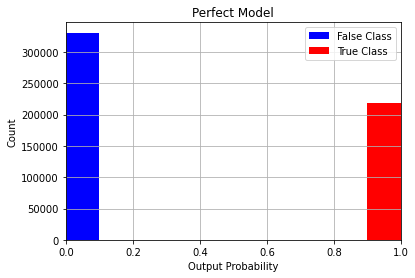

In [31]:
# Salida real. Como sería un modelo perfecto
fig, ax1 = plt.subplots(1,1)
ax1.hist(y_final[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(y_final[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Perfect Model')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

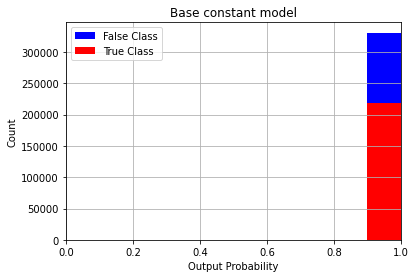

In [32]:
# Constant model
predictions = base_model.predict_proba(df_final)
fig, ax1 = plt.subplots(1,1)
ax1.hist(predictions[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(predictions[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Base constant model')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

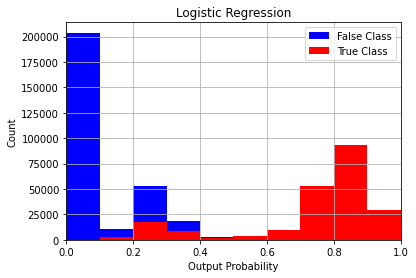

In [33]:
# Logistic model
predictions = lr_model.predict_proba(df_final)
predictions = predictions[:,1]

fig, ax1 = plt.subplots(1,1)
ax1.hist(predictions[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(predictions[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Logistic Regression')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

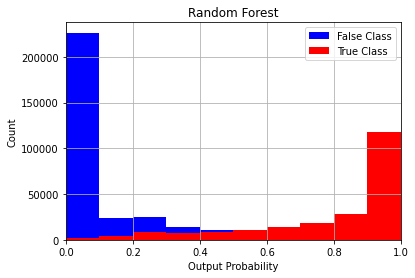

In [34]:
# Random Forest model
predictions = rf_model.predict_proba(df_final)
predictions = predictions[:,1]
fig, ax1 = plt.subplots(1,1)
ax1.hist(predictions[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(predictions[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Random Forest')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

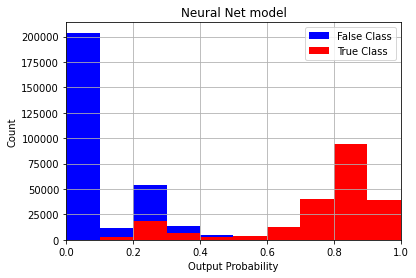

In [35]:
# Deep Learning Model
predictions = deep_model.predict_proba(df_final)
fig, ax1 = plt.subplots(1,1)
ax1.hist(predictions[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(predictions[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Neural Net model')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

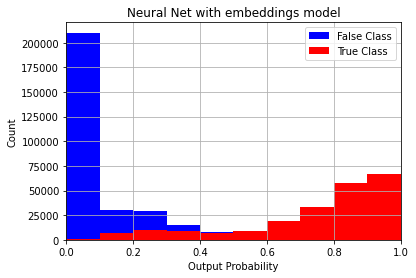

In [36]:
# Deep Learning with embeddings Model
predictions = deep_emb_model.predict_proba(df_final, user_index, product_index)
fig, ax1 = plt.subplots(1,1)
ax1.hist(predictions[y_final==0], bins=10, range=(0,1), color='blue', label='False Class')
ax1.hist(predictions[y_final==1], bins=10, range=(0,1), color='red', label='True Class')
ax1.set_xlim([0, 1])
plt.title('Neural Net with embeddings model')
plt.xlabel('Output Probability')
plt.ylabel('Count')
plt.legend()
plt.show()